In [23]:
# Translation
import googletrans
from googletrans import Translator


# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Text processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer

# K-Means
from sklearn                          import cluster
from sklearn.feature_extraction.text  import TfidfVectorizer, CountVectorizer
from sklearn.metrics                  import silhouette_samples, silhouette_score
from sklearn.preprocessing            import normalize
from sklearn.cluster                  import KMeans

from sklearn                          import cluster
from sklearn.decomposition            import LatentDirichletAllocation
from sklearn.model_selection          import GridSearchCV
from sklearn.decomposition            import PCA

# Visualization and Analysis
from wordcloud                        import WordCloud
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# load data

In [4]:
df = pd.read_csv('2021_Cities_Water_Security_Risks.csv', encoding="utf-8")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Questionnaire Name                       2349 non-null   object
 1   Account Number                           2349 non-null   int64 
 2   Account Name                             2349 non-null   object
 3   Country                                  2349 non-null   object
 4   CDP Region                               2349 non-null   object
 5   ParentSection                            2349 non-null   object
 6   Section                                  2349 non-null   object
 7   Question Number                          2349 non-null   object
 8   Question Name                            2349 non-null   object
 9   Row Number                               2349 non-null   int64 
 10  Water security risk drivers              2137 non-null   obj

,Questionnaire Name,Account Number,Account Name,Country,CDP Region,ParentSection,Section,Question Number,Question Name,Row Number,Water security risk drivers,Anticipated timescale,Estimated magnitude of potential impact,Estimated probability of impact,Risk description
0,Cities 2021,1093,"City of Atlanta, GA",United States of America,North America,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,1,Increased water stress,Short-term (by 2025),Serious,NaN,The city depends on one river for water supply...
1,Cities 2021,1093,"City of Atlanta, GA",United States of America,North America,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,2,Higher water prices,Current,Serious,NaN,The water cost burden is felt across all ZIP c...
2,Cities 2021,1184,"City of Austin, TX",United States of America,North America,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,1,Increased water stress,Short-term (by 2025),Extremely serious,High,Central Texas is drought prone and we depend o...
3,Cities 2021,1499,Ajuntament de Barcelona,Spain,Europe,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,1,Increased water stress,Current,Serious,Medium-high,The downscaling of the climate projections at ...
4,Cities 2021,1499,Ajuntament de Barcelona,Spain,Europe,14. Water Security,Water Supply,14.2a,Please identify the risks to your city’s water...,2,Declining water quality,Medium-term (by 2050),Less Serious,Medium,A reduction in water resources availability c...


# First, Water Security Risk Drivers

In [5]:
df1 = df[['Country','Account Name', 'CDP Region','Water security risk drivers']]
df1.dropna(inplace=True)
df1=df1.drop_duplicates()

# Transfer any row begins with "Other" and "Question not applicable" to "Other"
df1[df1['Water security risk drivers'].str.contains('Other')] = 'Other'
df1[df1['Water security risk drivers'].str.contains('Question not applicable')] = 'Other'
df1['Water security risk drivers'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Other                                               513
Increased water stress                              241
Declining water quality                             225
Inadequate or ageing water supply infrastructure    190
Increased water demand                              156
Increased water scarcity                            146
Drought                                             145
Severe weather events                                99
Higher water prices                                  89
Pollution incidents                                  42
Change in land-use                                   38
Environmental regulations                            36
Energy supply issues                                 32
Rationing of municipal water supply                  25
Ecosystem vulnerability                              19
Unauthorised/unregistered water connections          18
Increased levels of plastic in freshwater bodies     16
Water infestation/disease                       

In [6]:
len(df1)

2045

In [7]:
# Drop the rows "Other"
df1['Risk_drivers'] = df1[["Water security risk drivers"]]
df_risk_drivers = df1[df1.Risk_drivers != 'Other'].reset_index(drop=True)
df_risk_drivers['Risk_drivers'].value_counts()

Increased water stress                              241
Declining water quality                             225
Inadequate or ageing water supply infrastructure    190
Increased water demand                              156
Increased water scarcity                            146
Drought                                             145
Severe weather events                                99
Higher water prices                                  89
Pollution incidents                                  42
Change in land-use                                   38
Environmental regulations                            36
Energy supply issues                                 32
Rationing of municipal water supply                  25
Ecosystem vulnerability                              19
Unauthorised/unregistered water connections          18
Increased levels of plastic in freshwater bodies     16
Water infestation/disease                            15
Name: Risk_drivers, dtype: int64

In [8]:
df_risk_driver_count = df_risk_drivers['Risk_drivers'].value_counts()
df_risk_driver_count = df_risk_driver_count.reset_index().rename(columns = {'index':"Risk_driver", "Risk_drivers":"Counts"})
df_risk_driver_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Risk_driver  17 non-null     object
 1   Counts       17 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


In [9]:
df_risk_drivers_sort = df_risk_driver_count.sort_values(['Counts'], ascending=False).reset_index()
df_risk_drivers_sort.head(5)

,index,Risk_driver,Counts
0,0,Increased water stress,241
1,1,Declining water quality,225
2,2,Inadequate or ageing water supply infrastructure,190
3,3,Increased water demand,156
4,4,Increased water scarcity,146


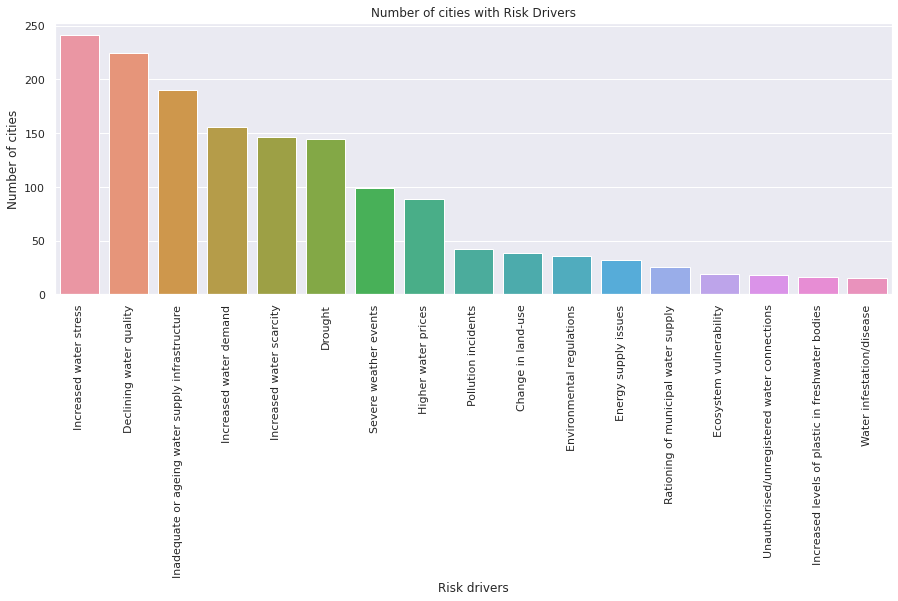

In [10]:
# Plot the Water Security risk drivers count value
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.barplot(x = "Risk_driver", y="Counts", data=df_risk_drivers_sort).set(title="Number of cities with Risk Drivers")
plt.xticks(rotation=90)

plt.ylabel('Number of cities')
plt.xlabel('Risk drivers')
plt.savefig("Water_risk_drivers_count.png")
plt.show()

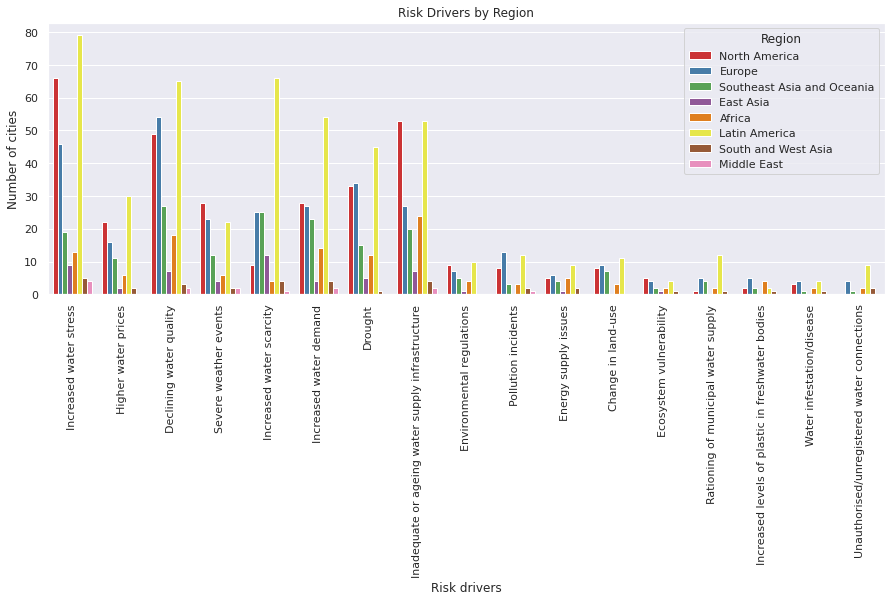

In [11]:
# Plot the Water Security risk drivers by regions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.countplot(hue='CDP Region',x = "Risk_drivers", data=df_risk_drivers, palette='Set1').set(title="Risk Drivers by Region")
plt.xticks(rotation=90)

plt.legend(loc='upper right', title='Region')
plt.ylabel('Number of cities')
plt.xlabel('Risk drivers')
plt.savefig("Water_risk_drivers_by_region.png")
plt.show()

### Exploring Water Security Risk Drivers by Region/Countries

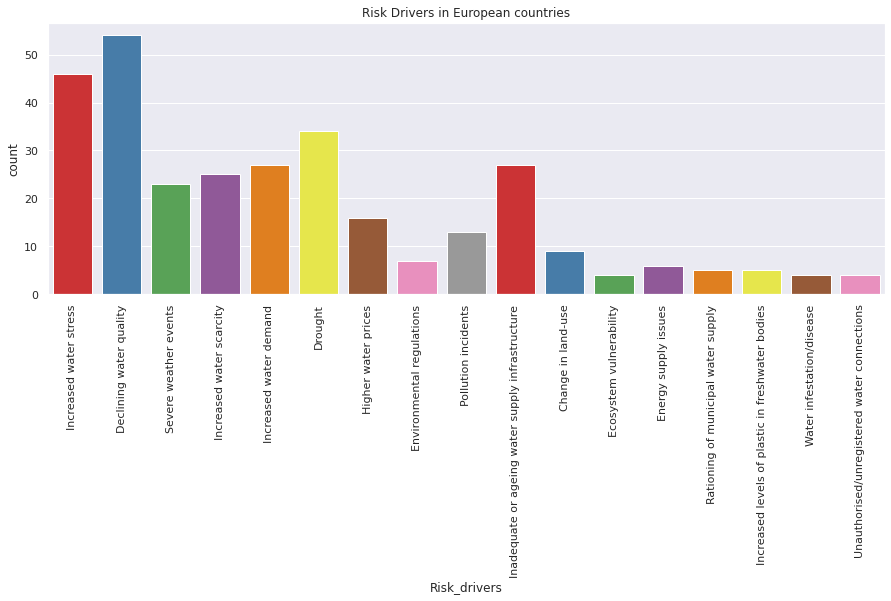

In [12]:
# Exloring Water security risk drivers in Europe
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.countplot(x = "Risk_drivers", 
                  data=df_risk_drivers[df_risk_drivers["CDP Region"]=="Europe"],
                  palette='Set1'
                 ).set(title="Risk Drivers in European countries")
plt.xticks(rotation=90)
plt.show()

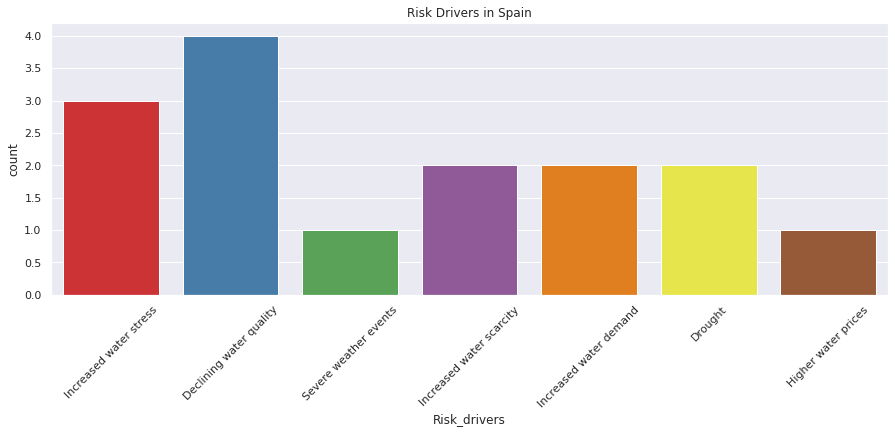

In [13]:
# Exloring water security risk drivers in Spain
df_risk_drivers[df_risk_drivers["Country"]=="Spain"]
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.countplot(x = "Risk_drivers", 
                  data=df_risk_drivers[df_risk_drivers["Country"]=="Spain"], 
                  palette='Set1'
                 ).set(title="Risk Drivers in Spain")
plt.xticks(rotation=45)
plt.show()

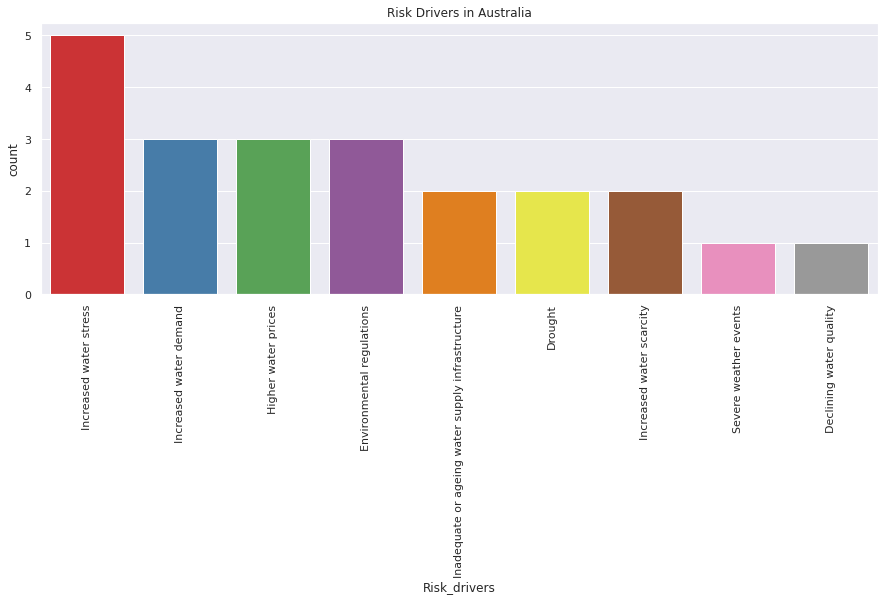

In [14]:
# Exloring water security risk drivers in Australia
df_risk_drivers[df_risk_drivers["Country"]=="Australia"]
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.countplot(x = "Risk_drivers", 
                  data=df_risk_drivers[df_risk_drivers["Country"]=="Australia"], 
                  palette='Set1'
                 ).set(title="Risk Drivers in Australia")
plt.xticks(rotation=90)
plt.show()

# Second, Risk Description

In [15]:
df2 = df[['Country','Account Name', 'CDP Region', 'Risk description']]

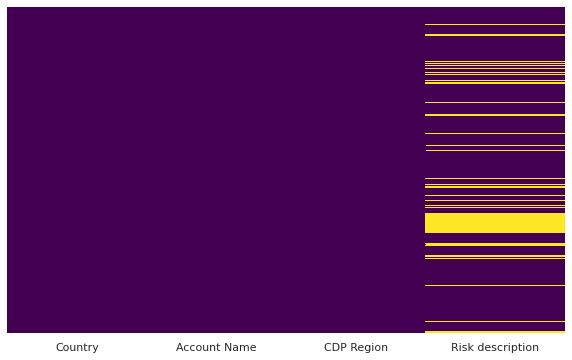

In [16]:
plt.figure(figsize = (10, 6))
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           2349 non-null   object
 1   Account Name      2349 non-null   object
 2   CDP Region        2349 non-null   object
 3   Risk description  1944 non-null   object
dtypes: object(4)
memory usage: 73.5+ KB


In [18]:
df2['description'] = df['Risk description'].map(str)
df2.dropna(inplace=True)
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1944 entries, 0 to 2348
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           1944 non-null   object
 1   Account Name      1944 non-null   object
 2   CDP Region        1944 non-null   object
 3   Risk description  1944 non-null   object
 4   description       1944 non-null   object
dtypes: object(5)
memory usage: 91.1+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Country,Account Name,CDP Region,Risk description,description
0,United States of America,"City of Atlanta, GA",North America,The city depends on one river for water supply...,The city depends on one river for water supply...
1,United States of America,"City of Atlanta, GA",North America,The water cost burden is felt across all ZIP c...,The water cost burden is felt across all ZIP c...
2,United States of America,"City of Austin, TX",North America,Central Texas is drought prone and we depend o...,Central Texas is drought prone and we depend o...
3,Spain,Ajuntament de Barcelona,Europe,The downscaling of the climate projections at ...,The downscaling of the climate projections at ...
4,Spain,Ajuntament de Barcelona,Europe,A reduction in water resources availability c...,A reduction in water resources availability c...


# TEXTING CLUSTER

First we define a function to make lowercase and  remove 'question not available'

In [19]:
def lower_na(x):
    y = x.lower()
    if y == 'question not applicable':
        return ''
    else:
        return y

In [20]:
# Transfering all text to lower cases
df2['new_desc'] = df2['description'].apply(lambda x: lower_na(x))
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,Account Name,CDP Region,Risk description,description,new_desc
0,United States of America,"City of Atlanta, GA",North America,The city depends on one river for water supply...,The city depends on one river for water supply...,the city depends on one river for water supply...
1,United States of America,"City of Atlanta, GA",North America,The water cost burden is felt across all ZIP c...,The water cost burden is felt across all ZIP c...,the water cost burden is felt across all zip c...
2,United States of America,"City of Austin, TX",North America,Central Texas is drought prone and we depend o...,Central Texas is drought prone and we depend o...,central texas is drought prone and we depend o...
3,Spain,Ajuntament de Barcelona,Europe,The downscaling of the climate projections at ...,The downscaling of the climate projections at ...,the downscaling of the climate projections at ...
4,Spain,Ajuntament de Barcelona,Europe,A reduction in water resources availability c...,A reduction in water resources availability c...,a reduction in water resources availability c...


In [21]:
# Doing translaion the text to English
translator = Translator()
df2['translated_value'] = df2['new_desc'].apply(lambda x: translator.translate(x, dest='en').text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# Merging all cities have the same country
df2['translated_value']=df2['translated_value'].apply(lambda x: x+ ' ')
aggregation_functions = {'translated_value': 'sum'}
df_country_risk_dscrt = df2.groupby(df['Country']).aggregate(aggregation_functions)
df_country_risk_dscrt = df_country_risk_dscrt.reset_index()
df_country_risk_dscrt.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,translated_value
0,Argentina,snowfall in high mountains is scarce and the ...
1,Australia,melbourne water analysed the effect of greater...
2,Bangladesh,crysis of drinking water increases water born ...
3,Belgium,agriculture: increased water needs and risk of...
4,Bolivia (Plurinational State of),because from the same source it is used for...


In [23]:
len(df_country_risk_dscrt)

87

There are 87 countries in the dataset. Now we have country level data with combined risk description. Idea is to cluster the countries based on the risk description.

## We apply the TF-IDF fuction for text clustering
We apply the TF-IDF function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [24]:
corpus = df_country_risk_dscrt['translated_value'].to_list()

**Corpus Processing: For this method, the function that we appy for corpus processing is "UNIDECODE"**

In [25]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord


In [26]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language) + ['water']
    param_stemmer = SnowballStemmer(language)

    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
             
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        
        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [27]:
# Processing corpus
language = 'english'
new_corpus = processCorpus(corpus, language)

In [28]:
# We make new column in df2 as named corpus
df_country_risk_dscrt['corpus'] = new_corpus
df_country_risk_dscrt.head()

,Country,translated_value,corpus
0,Argentina,snowfall in high mountains is scarce and the ...,snowfal high mountain scarc amount meltwat exp...
1,Australia,melbourne water analysed the effect of greater...,melbourn analys effect greater consumpt caus p...
2,Bangladesh,crysis of drinking water increases water born ...,crysi drink increas born diseas
3,Belgium,agriculture: increased water needs and risk of...,agricultur increas need risk stress pollut gro...
4,Bolivia (Plurinational State of),because from the same source it is used for...,sourc use agricultur livestock human consumpt ...


**Statistical Weighting of Words**

In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(new_corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

87 rows


,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
atuel,0.232807,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
diamant,0.232807,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
hydroelectr,0.213076,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.0,0.009518,0.000000,0.0,0.0,0.0,0.0
system,0.179051,0.032857,0.0,0.0,0.000000,0.102803,0.0,0.0,0.0,0.053083,...,0.24112,0.0,0.023124,0.0,0.083976,0.000000,0.0,0.0,0.0,0.0
basin,0.164340,0.022618,0.0,0.0,0.076679,0.159997,0.0,0.0,0.0,0.000000,...,0.00000,0.0,0.000000,0.0,0.016516,0.185585,0.0,0.0,0.0,0.0


## k means

In [30]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')
        kmeans_results.update( {k : kmeans.fit(data)} )      
    return kmeans_results

**Silhouette Score**: The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [31]:
best_clusters = 0 # best cluster number which you will get
previous_silh_avg = 0.0
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters, init='k-means++', random_state=1)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=87)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters
print("No of Clusters:", best_clusters)
# K-Means Implementation
num_clusters = best_clusters  
km = KMeans(n_clusters=num_clusters, init='k-means++', random_state=1)  
km.fit(X)  
clusters = km.labels_.tolist()  
df_country_risk_dscrt['label'] = clusters  
print("Cluster Count")
print(df_country_risk_dscrt['label'].value_counts())

No of Clusters: 2
Cluster Count
1    48
0    39
Name: label, dtype: int64


There are 47 countries in the cluster 1, and 40 countries in cluster 2.

In [32]:
#show more rows
pd.set_option('display.max_rows', 100)

In [33]:
df_country_risk_dscrt[df_country_risk_dscrt['label'] == 1]

,Country,translated_value,corpus,label
1,Australia,melbourne water analysed the effect of greater...,melbourn analys effect greater consumpt caus p...,1
4,Bolivia (Plurinational State of),because from the same source it is used for...,sourc use agricultur livestock human consumpt ...,1
5,Brazil,two scenarios were studied with current climat...,two scenario studi current climat pattern dema...,1
6,Bulgaria,the population of the city is constantly incre...,popul citi constant increas main sourc surfac ...,1
10,Canada,reduced snowpack in winter could reduce storag...,reduc snowpack winter could reduc storag reser...,1
11,Chile,"the underground aquifers are drying up, especi...",underground aquif dri especi northwest sector ...,1
13,"China, Hong Kong Special Administrative Region","hong kong is an international city, reliable w...",hong kong intern citi reliabl suppli essenti d...,1
14,Colombia,there could be a risk on the resource availabi...,could risk resourc avail popul comparison curr...,1
15,Costa Rica,risk is high because projects are needed to pr...,risk high project need provid metropolitan aqu...,1
19,Denmark,if the national or regional government decid...,nation region govern decid close groundwat wel...,1


In [ ]:
df_country_risk_dscrt[df_country_risk_dscrt['label'] == 0]

,Country,translated_value,corpus,label
0,Argentina,snowfall in high mountains is scarce and the ...,snowfal high mountain scarc amount meltwat exp...,0
2,Bangladesh,crysis of drinking water increases water born ...,crysi drink increas born diseas,0
3,Belgium,agriculture: increased water needs and risk of...,agricultur increas need risk stress pollut gro...,0
8,Burundi,little severe,littl sever,0
12,China,,,0
13,"China, Hong Kong Special Administrative Region","hong kong is an international city, reliable w...",hong kong intern citi reliabl suppli essenti d...,0
16,Croatia,,,0
17,Côte d'Ivoire,increase in water demand linked to urban spraw...,increas demand link urban sprawl groundwat pol...,0
18,Democratic Republic of the Congo,disappearance of water catchment sites f...,disappear catchment site follow anarch illeg c...,0
21,Eswatini,the incidence of drought is projected to be mo...,incid drought project frequent due climat chan...,0


**We apply the Wordclouds to show the most popular words in each cluster.**

In [34]:
# First, we define the function
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

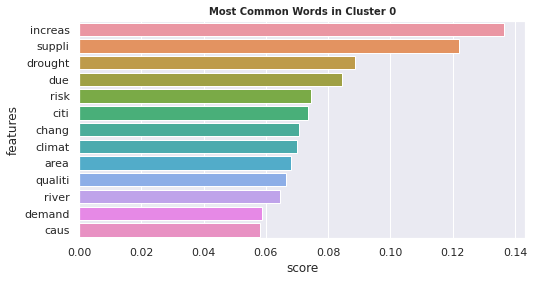

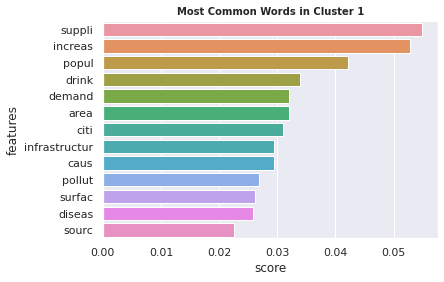

In [35]:
# Running Kmeans
k = 2
kmeans_results = run_KMeans(k, final_df)

# Plot common words
best_result =2
kmeans = kmeans_results.get(best_result)
final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [36]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )
    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(15,6))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

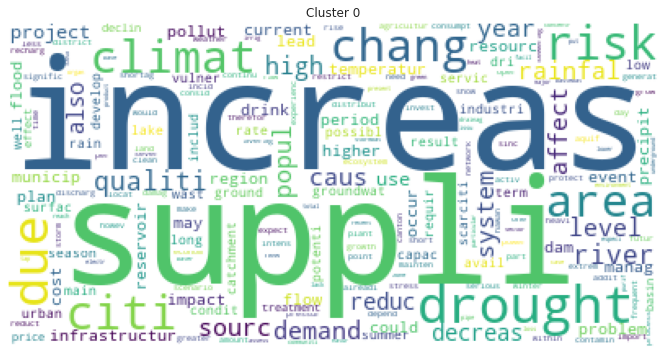

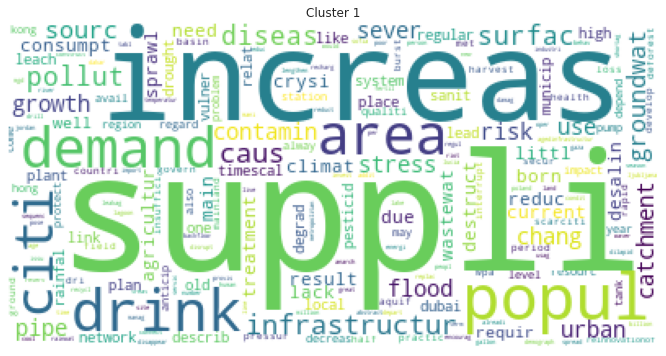

In [39]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [40]:
# We would like to see how many cities in each region locating in cluster 1 or cluster 2
merge_2 = pd.merge(df2, df_country_risk_dscrt, left_on='Country', right_on='Country')
merge_2 = merge_2[["Account Name",'Country', 'CDP Region', 'label']]
merge_2.head()


,Account Name,Country,CDP Region,label
0,"City of Atlanta, GA",United States of America,North America,1
1,"City of Atlanta, GA",United States of America,North America,1
2,"City of Austin, TX",United States of America,North America,1
3,"City of Burlington, VT",United States of America,North America,1
4,"City of Chicago, IL",United States of America,North America,1


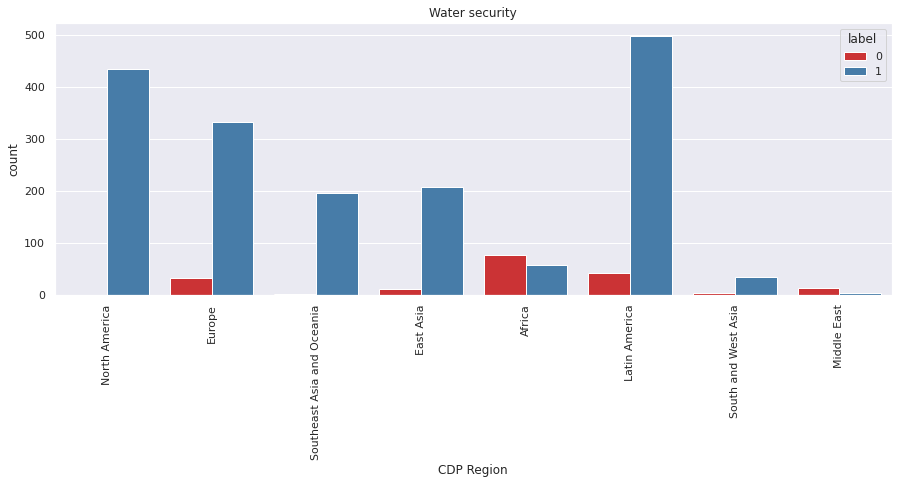

In [41]:
# Plot the Water Security risk drivers by regions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.countplot(hue='label',x = "CDP Region", data=merge_2, palette='Set1').set(title="Water security")
plt.xticks(rotation=90)

plt.legend(loc='upper right', title='label')
plt.show()

**Text Clustering for Cities**

In [42]:
# Aggregate cities
aggregation_functions = {'translated_value': 'sum'}
df_city_risk_dscrt = df2.groupby(df['Account Name']).aggregate(aggregation_functions)
df_city_risk_dscrt = df_city_risk_dscrt.reset_index()
df_city_risk_dscrt.head()

,Account Name,translated_value
0,Aarhus Kommune,
1,"Abington Township, PA",unknown as this has not been formally assessed...
2,Abuja Federal Capital Territory,pipe borne water network in the federal capita...
3,Accra Metropolitan Assembly,a major water reservoir outside of the city is...
4,Adana Metropolitan Municipality,


In [43]:
len(df_city_risk_dscrt)

982

In [44]:
# remove blank rows
df_city_risk_dscrt['translated_value'].replace(' ', np.nan, inplace=True)
df_city_risk_dscrt.dropna(subset=['translated_value'], inplace=True)

In [45]:
len(df_city_risk_dscrt)

537

In [46]:
corpus = df_city_risk_dscrt['translated_value'].to_list()

In [47]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [48]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language) + ['water']
    param_stemmer = SnowballStemmer(language)

    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
             
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)

        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        
        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [49]:
# Processing corpus
language = 'english'
new_corpus = processCorpus(corpus, language)

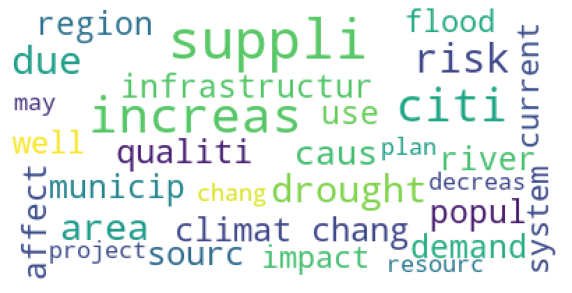

In [50]:
# General Word Cloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(new_corpus))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off');

The most frequent words are supply, increases, demand, infrastructure, drought, climate change, etc

In [51]:
# We make new column in df3 as named corpus
df_city_risk_dscrt['corpus'] = new_corpus
df_city_risk_dscrt.rename(columns = {'Account Name': "City"}, inplace = True)
df_city_risk_dscrt.dropna(inplace = True)
df_city_risk_dscrt.head()

,City,translated_value,corpus
1,"Abington Township, PA",unknown as this has not been formally assessed...,unknown formal assess climat mitig plan public...
2,Abuja Federal Capital Territory,pipe borne water network in the federal capita...,pipe born network feder capit citi complet sup...
3,Accra Metropolitan Assembly,a major water reservoir outside of the city is...,major reservoir outsid citi current threaten e...
5,Addis Ababa City Administration,lc problemillegal connection of septic tank to...,problemilleg connect septic tank road side sto...
6,Aipromades Lago de Chapala,"Loss of forests, extraction and misuse of wate...",loss forest extract misus compromis access tho...


In [52]:
# We would like to see how many cities in each region 
merge_3 = pd.merge(df_city_risk_dscrt, df2, right_on='Account Name', left_on='City')
merge_3 = merge_3[["City",'Country', 'CDP Region', 'corpus']]
merge_3.drop_duplicates(inplace=True)
merge_3.reset_index(inplace=True)
merge_3.head()

,index,City,Country,CDP Region,corpus
0,0,"Abington Township, PA",United States of America,North America,unknown formal assess climat mitig plan public...
1,3,Abuja Federal Capital Territory,Nigeria,Africa,pipe born network feder capit citi complet sup...
2,6,Accra Metropolitan Assembly,Ghana,Africa,major reservoir outsid citi current threaten e...
3,7,Addis Ababa City Administration,Ethiopia,Africa,problemilleg connect septic tank road side sto...
4,10,Aipromades Lago de Chapala,Mexico,Latin America,loss forest extract misus compromis access tho...


In [53]:
merge_3["CDP Region"].value_counts()

Latin America                 174
North America                 131
Europe                        100
Southeast Asia and Oceania     64
Africa                         36
East Asia                      19
South and West Asia             8
Middle East                     5
Name: CDP Region, dtype: int64

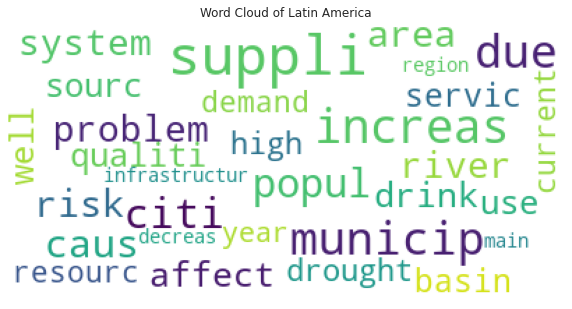

In [54]:
# Wordcloud of Latin America
latin_american = merge_3[merge_3["CDP Region"]=="Latin America"]
text_latin_american = latin_american.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_latin_american))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of Latin America")
plt.axis('off');
plt.savefig("Word Cloud of Latin America.png")

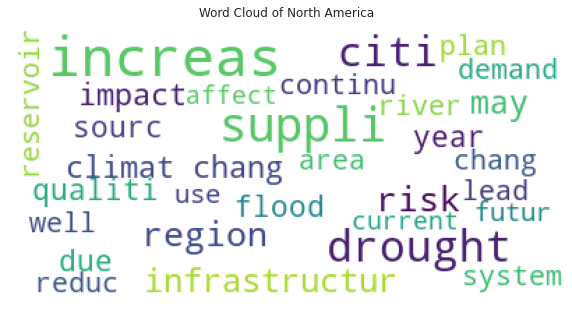

In [55]:
# Wordcloud of North America 
text_df = merge_3[merge_3["CDP Region"]=="North America"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of North America")
plt.axis('off');
plt.savefig("Word Cloud of North America.png")

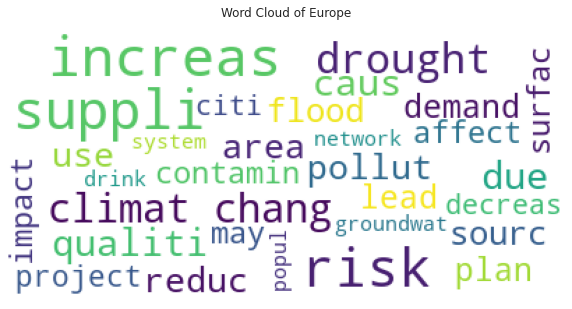

In [56]:
# Wordcloud of Europe 
text_df = merge_3[merge_3["CDP Region"]=="Europe"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of Europe")
plt.axis('off');
plt.savefig("Word Cloud of Europe.png")


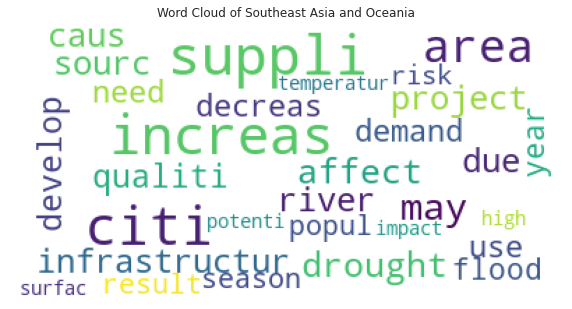

In [57]:
# Wordcloud of South Asia
text_df = merge_3[merge_3["CDP Region"]=="Southeast Asia and Oceania"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of Southeast Asia and Oceania")
plt.axis('off');
plt.savefig("Word Cloud of Southeast Asia and Oceania.png")


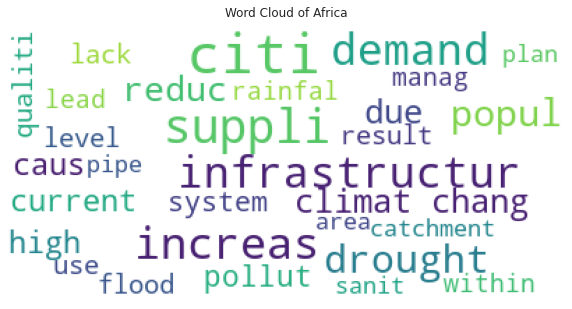

In [58]:
# Wordcloud of Africa
text_df = merge_3[merge_3["CDP Region"]=="Africa"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of Africa")
plt.axis('off');
plt.savefig("Word Cloud of Africa.png")


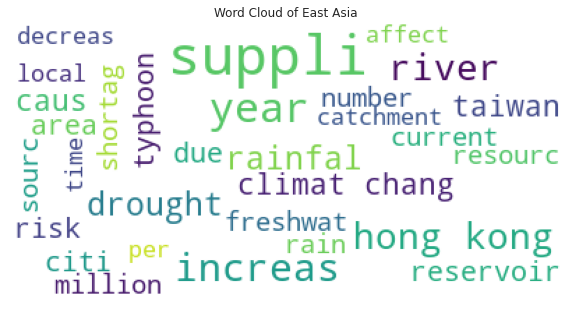

In [59]:
# Wordcloud of East Asia
text_df = merge_3[merge_3["CDP Region"]=="East Asia"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of East Asia")
plt.axis('off');
plt.savefig("Word Cloud of East Asia.png")


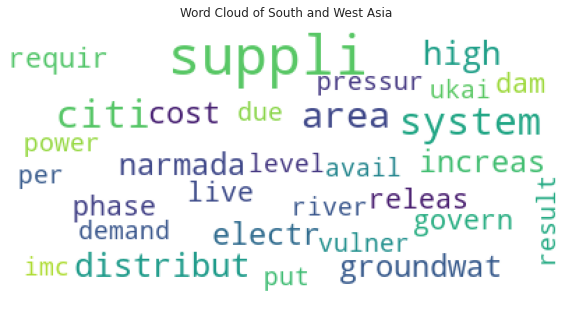

In [60]:
# Wordcloud of South and West Asia 
text_df = merge_3[merge_3["CDP Region"]=="South and West Asia"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of South and West Asia")
plt.axis('off');
plt.savefig("Word Cloud of South and West Asia.png")


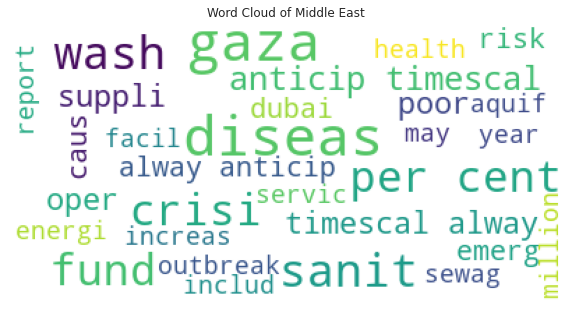

In [61]:
# Wordcloud of Middle East
text_df = merge_3[merge_3["CDP Region"]=="Middle East"]
text_list = text_df.corpus.to_list()
wordcloud = WordCloud(background_color='white',
                      stopwords=stopwords,
                      max_words=30,
                      max_font_size=40,
                      random_state=42).generate(str(text_list))
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.title("Word Cloud of Middle East")
plt.axis('off');
plt.savefig("Word Cloud of Middle East.png")


# **Latent Dirichlet Allocation**

In [63]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english')

In [64]:
tf_matrix = tf_vectorizer.fit_transform(new_corpus)

In [65]:
tf_df = pd.DataFrame(tf_matrix.toarray())
tf_feature_names = tf_vectorizer.get_feature_names_out()
tf_df.columns = tf_feature_names
tf_df

,abandon,abil,abl,abnorm,absenc,abstract,acceler,access,accid,accommod,...,wors,worsen,worst,worth,wrmp,year,years,yield,yorkshir,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Define Search Param
search_params = {'n_components': [2,3,4,5,6,7,8], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state = 17)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf_matrix)


GridSearchCV(estimator=LatentDirichletAllocation(random_state=17),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5, 6, 7, 8]})

In [67]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -40246.598633272326
Model Perplexity:  710.3078367310542


In [68]:
lda = LatentDirichletAllocation(n_components=2,random_state=17, learning_decay=0.5)

In [69]:
lda.fit(tf_matrix) 

LatentDirichletAllocation(learning_decay=0.5, n_components=2, random_state=17)

In [70]:
df = pd.DataFrame(lda.components_)
df.columns = tf_feature_names
df

,abandon,abil,abl,abnorm,absenc,abstract,acceler,access,accid,accommod,...,wors,worsen,worst,worth,wrmp,year,years,yield,yorkshir,zone
0,0.687631,4.022246,3.520411,1.808583,0.513313,16.719451,0.884505,2.46461,0.657297,1.584469,...,0.51354,9.026217,0.572509,0.916006,0.786032,127.267237,2.48369,7.689265,5.282726,15.858005
1,4.312369,6.977754,12.479589,1.191417,2.486687,1.280549,4.115495,28.53539,8.342703,3.415531,...,4.48646,2.973783,3.427491,2.083994,6.213968,58.732763,0.51631,1.310735,0.717274,8.141995


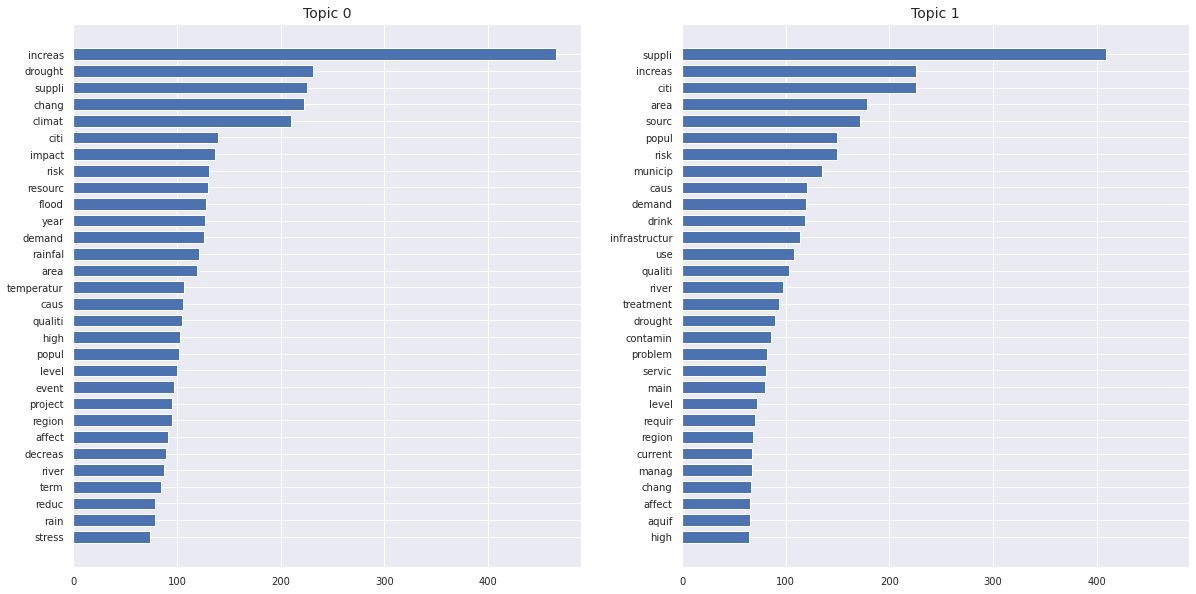

In [71]:
n_top_words = 30
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [tf_feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 14})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=10)

In [72]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=30)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29
Topic 0,increas,drought,suppli,chang,climat,citi,impact,risk,resourc,flood,...,event,project,region,affect,decreas,river,term,reduc,rain,stress
Topic 1,suppli,increas,citi,area,sourc,popul,risk,municip,caus,demand,...,main,level,requir,region,current,manag,chang,affect,aquif,high


In [73]:
# Log Likelyhood: Higher the better with 2 components
print("Log Likelihood: ", lda.score(tf_matrix))

Log Likelihood:  -180504.18175799586


In [74]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf_matrix)

# column names
topicnames = ["Topic" + str(i) for i in range(2)]

# index names
docnames = ["Doc" + str(i) for i in range(len(tf_df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic

,Topic0,Topic1,dominant_topic
Doc0,0.13,0.87,1
Doc1,0.03,0.97,1
Doc2,0.04,0.96,1
Doc3,0.03,0.97,1
Doc4,0.02,0.98,1
...,...,...,...
Doc532,0.22,0.78,1
Doc533,0.02,0.98,1
Doc534,0.09,0.91,1
Doc535,0.38,0.62,1


In [75]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,274
1,1,263


In [76]:
df_city_risk_dscrt.reset_index(inplace=True)

In [77]:
topic_col = df_document_topic['dominant_topic'].tolist()
df_city_topic = df_city_risk_dscrt
df_city_topic["topic"] = topic_col
df_city_topic = df_city_topic[["City", "translated_value", "corpus", "topic"]]

In [78]:
# We would like to see the dominant topic in each regions/country
merge_4 = pd.merge(df_city_topic, df2, right_on='Account Name', left_on='City')
merge_4 = merge_4[["City",'Country', 'CDP Region', 'translated_value_x','corpus', 'topic']]
merge_4.drop_duplicates(inplace=True)
merge_4.reset_index(inplace=True)
merge_4.head()

,index,City,Country,CDP Region,translated_value_x,corpus,topic
0,0,"Abington Township, PA",United States of America,North America,unknown as this has not been formally assessed...,unknown formal assess climat mitig plan public...,1
1,3,Abuja Federal Capital Territory,Nigeria,Africa,pipe borne water network in the federal capita...,pipe born network feder capit citi complet sup...,1
2,6,Accra Metropolitan Assembly,Ghana,Africa,a major water reservoir outside of the city is...,major reservoir outsid citi current threaten e...,1
3,7,Addis Ababa City Administration,Ethiopia,Africa,lc problemillegal connection of septic tank to...,problemilleg connect septic tank road side sto...,1
4,10,Aipromades Lago de Chapala,Mexico,Latin America,"Loss of forests, extraction and misuse of wate...",loss forest extract misus compromis access tho...,1


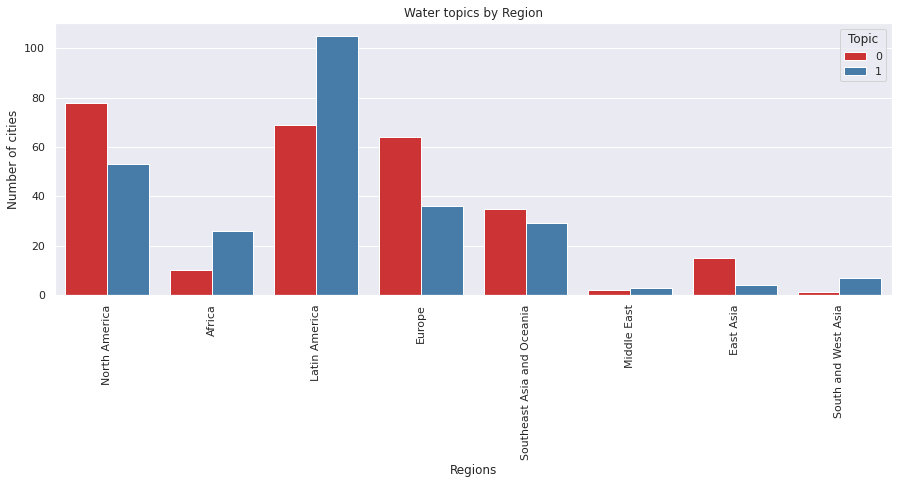

In [79]:
# Plot the Water Security risk drivers by regions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15, 5))

ax= sns.countplot(hue='topic',x = "CDP Region", data=merge_4, palette='Set1').set(title="Water topics by Region")
plt.xticks(rotation=90)

plt.legend(loc='upper right', title='Topic')
plt.ylabel('Number of cities')
plt.xlabel('Regions')
plt.savefig("Water_topic_by_region.png")
plt.show()

# **K-Means Clustering based on LDA Topics**

In [80]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(new_corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())


In [81]:
best_clusters = 0 # best cluster number which you will get
previous_silh_avg = 0.0
for n_clusters in range(2, 10):
    clusterer = KMeans(n_clusters, init='k-means++', random_state=1)
    cluster_labels = clusterer.fit_predict(tf_idf)
    silhouette_avg = silhouette_score(tf_idf, cluster_labels)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters
print("No of Clusters:", best_clusters)
# K-Means Implementation
num_clusters = best_clusters  
km = KMeans(n_clusters=num_clusters, init='k-means++', random_state=1)  
km.fit(tf_idf)  
clusters = km.labels_.tolist()  
df_city_risk_dscrt['label'] = clusters  
print("Cluster Count")
print(df_city_risk_dscrt['label'].value_counts())

No of Clusters: 2
Cluster Count
0    308
1    229
Name: label, dtype: int64


In [82]:
tf_idf

,abandon,abelardo,abil,abington,abl,abnorm,absenc,absolut,absorb,absorpt,...,young,yport,zamboanga,zapotillo,zealand,zero,zika,zip,zone,zurich
0,0.0,0.0,0.0,0.196375,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
534,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
535,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


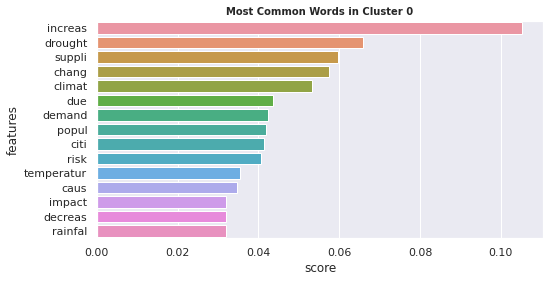

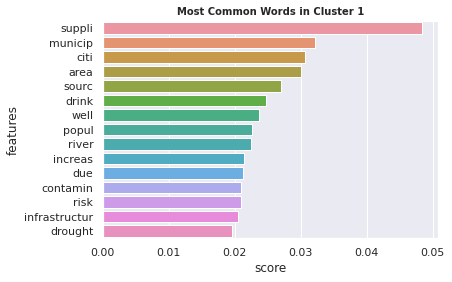

In [83]:
# Running Kmeans
k = 2
kmeans_results = run_KMeans(k, tf_idf)

# Plot common words
best_result =2
kmeans = kmeans_results.get(best_result)
final_df_array = tf_idf.to_numpy()
prediction = kmeans.predict(tf_idf)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 15)

In [84]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )
    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure(figsize=(15,6))
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

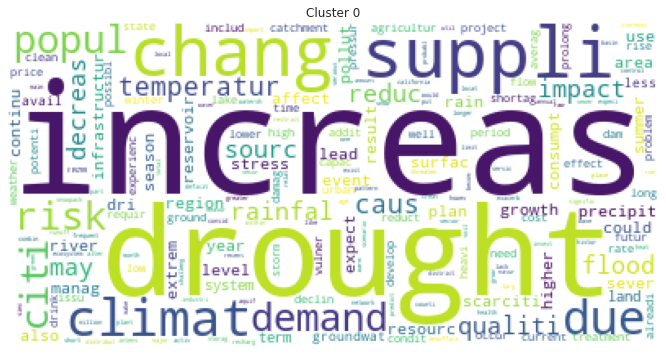

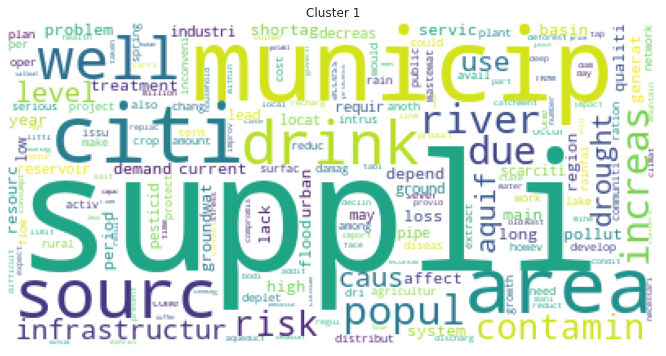

In [85]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = tf_idf.columns
generateWordClouds(centroids)

### Principal Component Anslysis

In [86]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf)
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

Text(0.5, 1.0, 'Scatter plot of K-means Cluster')

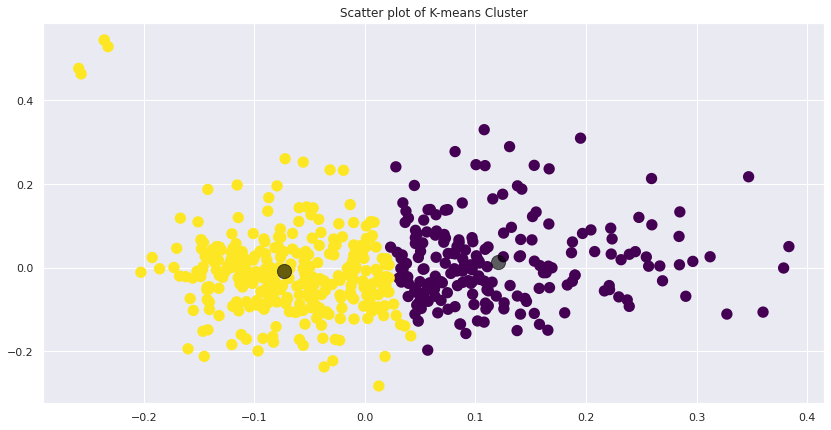

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);
plt.title("Scatter plot of K-means Cluster")

Text(0.5, 1.0, 'Scatter plot of K-means Cluster')

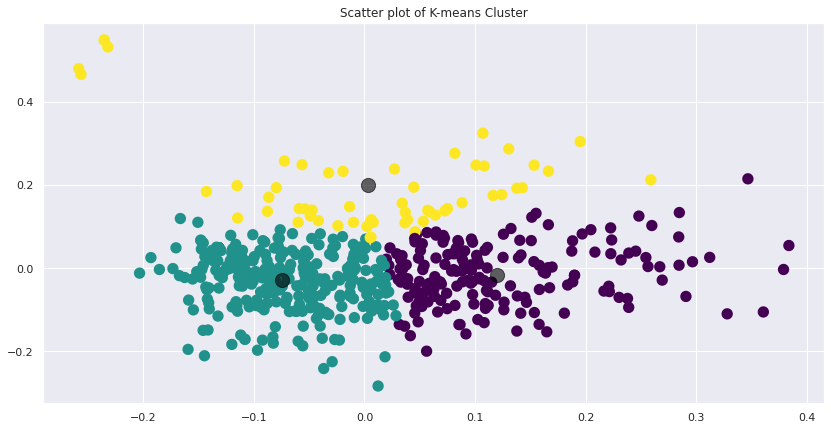

In [87]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)
plt.figure(figsize=(14, 7))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.6);
plt.title("Scatter plot of K-means Cluster")

Text(0.5, 1.0, 'Scatter plot of K-means Cluster')

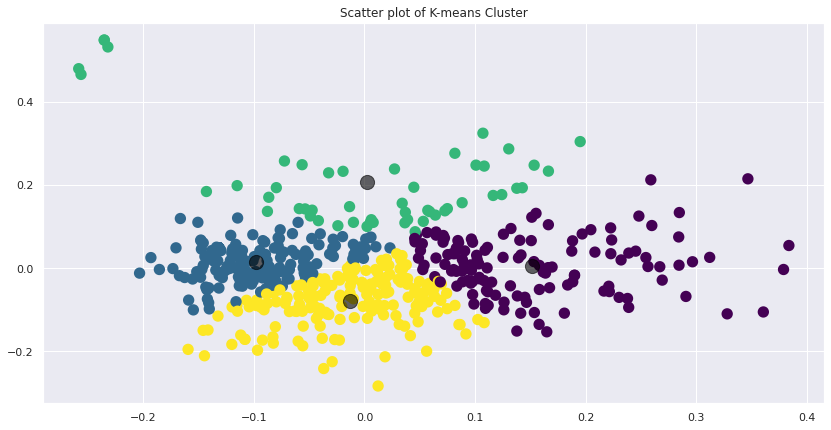

In [88]:
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)
plt.figure(figsize=(14, 7))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],  c='black', s=200, alpha=0.6);
plt.title("Scatter plot of K-means Cluster")